# A Simple Autoencoder

We'll start off by building a simple autoencoder to compress the MNIST dataset. With autoencoders, we pass input data through an encoder that makes a compressed representation of the input. Then, this representation is passed through a decoder to reconstruct the input data. Generally the encoder and decoder will be built with neural networks, then trained on example data.

![Autoencoder](assets/autoencoder_1.png)

In this notebook, we'll be build a simple network architecture for the encoder and decoder. Let's get started by importing our libraries and getting the dataset.

In [1]:
%matplotlib inline

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [2]:
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets('MNIST_data')

Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


Below I'm plotting an example image from the MNIST dataset. These are 28x28 grayscale images of handwritten digits.

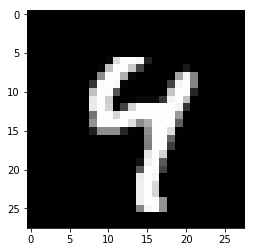

In [3]:
img = mnist.train.images[2]
plt.imshow(img.reshape((28, 28)), cmap='Greys_r')

In [4]:
# Looking into the dataset training and validation and testing
(mnist.train.images.shape, mnist.train.images.dtype, mnist.validation.images.shape, mnist.validation.images.dtype, 
mnist.test.images.shape, mnist.test.images.dtype) 

((55000, 784),
 dtype('float32'),
 (5000, 784),
 dtype('float32'),
 (10000, 784),
 dtype('float32'))

We'll train an autoencoder with these images by flattening them into 784 length vectors. The images from this dataset are already normalized such that the values are between 0 and 1. Let's start by building basically the simplest autoencoder with a **single ReLU hidden layer**. This layer will be used as the compressed representation. Then, the encoder is the input layer and the hidden layer. The decoder is the hidden layer and the output layer. Since the images are normalized between 0 and 1, we need to use a **sigmoid activation on the output layer** to get values matching the input.

![Autoencoder architecture](assets/simple_autoencoder.png)


> **Exercise:** Build the graph for the autoencoder in the cell below. The input images will be flattened into 784 length vectors. The targets are the same as the inputs. And there should be one hidden layer with a ReLU activation and an output layer with a sigmoid activation. Feel free to use TensorFlow's higher level API, `tf.layers`. For instance, you would use [`tf.layers.dense(inputs, units, activation=tf.nn.relu)`](https://www.tensorflow.org/api_docs/python/tf/layers/dense) to create a fully connected layer with a ReLU activation. The loss should be calculated with the cross-entropy loss, there is a convenient TensorFlow function for this `tf.nn.sigmoid_cross_entropy_with_logits` ([documentation](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits)). You should note that `tf.nn.sigmoid_cross_entropy_with_logits` takes the logits, but to get the reconstructed images you'll need to pass the logits through the sigmoid function.

In [37]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.8.0
Default GPU Device: /device:GPU:0


In [5]:
# Size of the encoding layer (the hidden layer)
h_units = 32
x_units = mnist.validation.images.shape[1]
print(h_units, x_units)

# input tensor
x = tf.placeholder(dtype=tf.float32, shape=(None, x_units))
print(x.shape, x.dtype)

32 784
(?, 784) <dtype: 'float32'>


In [6]:
def generator(x, x_units, h_units, trainable):

    # input to the hidden layer: x2h
    # encoded = tf.layers.dense(inputs_, encoding_dim, activation=tf.nn.relu)
    initial_value = tf.random_normal(dtype=tf.float32, mean=0.0, shape=[x_units, h_units], stddev=0.1)
    wg_x2h = tf.Variable(initial_value=initial_value, trainable=trainable)
    print(wg_x2h.shape, wg_x2h.dtype)
    h = tf.matmul(a=x, b=wg_x2h)
    h = tf.maximum(x=(0.1*h), y=h)
    print(h.shape, h.dtype)

    # hidden to outout which has the input size
    # Output layer logits
    # logits = tf.layers.dense(encoded, image_size, activation=None)
    initial_value = tf.random_normal(dtype=tf.float32, mean=0.0, shape=[h_units, x_units], stddev=0.1)
    wg_h2x = tf.Variable(initial_value=initial_value, trainable=trainable)
    print(wg_h2x.shape, wg_h2x.dtype)
    logits = tf.matmul(a=h, b=wg_h2x)
    # Sigmoid output from
    out = tf.sigmoid(x=logits)
    print(out.shape, out.dtype)
    
    return out, logits

In [38]:
g_out, g_logits = generator(h_units=h_units, trainable=True, x=x, x_units=x_units) 
g_loss_batch = tf.nn.sigmoid_cross_entropy_with_logits(labels=x, logits=g_logits)
g_loss = tf.reduce_mean(g_loss_batch)
g_opt = tf.train.AdamOptimizer().minimize(g_loss)

(784, 32) <dtype: 'float32_ref'>
(?, 32) <dtype: 'float32'>
(32, 784) <dtype: 'float32_ref'>
(?, 784) <dtype: 'float32'>


## Training

In [39]:
# Create the session
sess = tf.Session()

Here I'll write a bit of code to train the network. I'm not too interested in validation here, so I'll just monitor the training loss and the test loss afterwards. 

Calling `mnist.train.next_batch(batch_size)` will return a tuple of `(images, labels)`. We're not concerned with the labels here, we just need the images. Otherwise this is pretty straightfoward training with TensorFlow. We initialize the variables with `sess.run(tf.global_variables_initializer())`. Then, run the optimizer and get the loss with `batch_cost, _ = sess.run([cost, opt], feed_dict=feed)`.

In [40]:
# Looking into the batching technique
mnist.validation.num_examples, mnist.validation.images.shape, mnist.train.next_batch(batch_size=2)

(5000, (5000, 784), (array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]], dtype=float32),
  array([2, 0], dtype=uint8)))

In [41]:
epochs = 100
batch_size = mnist.validation.num_examples
sess.run(fetches=tf.global_variables_initializer())

train_loss_batch, valid_loss_batch = [], []
for e in range(epochs):
    
    # Training batches
    loss_batch = []
    for _ in range(mnist.train.num_examples//batch_size):
        Xarr, _ = mnist.train.next_batch(batch_size)
        feed_dict = {x:Xarr}
        lossarr, _ = sess.run(fetches=[g_loss, g_opt], feed_dict=feed_dict)
        loss_batch.append(lossarr)
    # Saving training loss batch
    train_loss_batch.append(np.mean(loss_batch))

    # Validation batches
    loss_batch = []
    for _ in range(mnist.validation.num_examples//batch_size):
        Xarr, _ = mnist.train.next_batch(batch_size)
        feed_dict = {x:Xarr}
        lossarr = sess.run(fetches=g_loss, feed_dict=feed_dict)
        loss_batch.append(lossarr)
    # Saving training loss batch
    valid_loss_batch.append(np.mean(loss_batch))

    print("Epoch: {}/{}...".format(e+1, epochs),
          "Training loss: {:.4f}".format(train_loss_batch[e]),
          "Validation loss: {:.4f}".format(valid_loss_batch[e]))

Epoch: 1/100... Training loss: 0.6821 Validation loss: 0.6487
Epoch: 2/100... Training loss: 0.6013 Validation loss: 0.5321
Epoch: 3/100... Training loss: 0.4674 Validation loss: 0.3970
Epoch: 4/100... Training loss: 0.3547 Validation loss: 0.3163
Epoch: 5/100... Training loss: 0.3000 Validation loss: 0.2858
Epoch: 6/100... Training loss: 0.2783 Validation loss: 0.2714
Epoch: 7/100... Training loss: 0.2660 Validation loss: 0.2613
Epoch: 8/100... Training loss: 0.2575 Validation loss: 0.2524
Epoch: 9/100... Training loss: 0.2495 Validation loss: 0.2460
Epoch: 10/100... Training loss: 0.2422 Validation loss: 0.2372
Epoch: 11/100... Training loss: 0.2353 Validation loss: 0.2317
Epoch: 12/100... Training loss: 0.2287 Validation loss: 0.2249
Epoch: 13/100... Training loss: 0.2225 Validation loss: 0.2191
Epoch: 14/100... Training loss: 0.2170 Validation loss: 0.2146
Epoch: 15/100... Training loss: 0.2110 Validation loss: 0.2086
Epoch: 16/100... Training loss: 0.2067 Validation loss: 0.2049
E

In [42]:
# Testing the loss of the trained model
Xtest = mnist.test.images
lossarr = sess.run(fetches=g_loss, feed_dict={x: Xtest})
print('Testing loss:', lossarr)

Testing loss: 0.11408872


## Checking out the results

Below I've plotted some of the test images along with their reconstructions. For the most part these look pretty good except for some blurriness in some parts.

(10, 784)


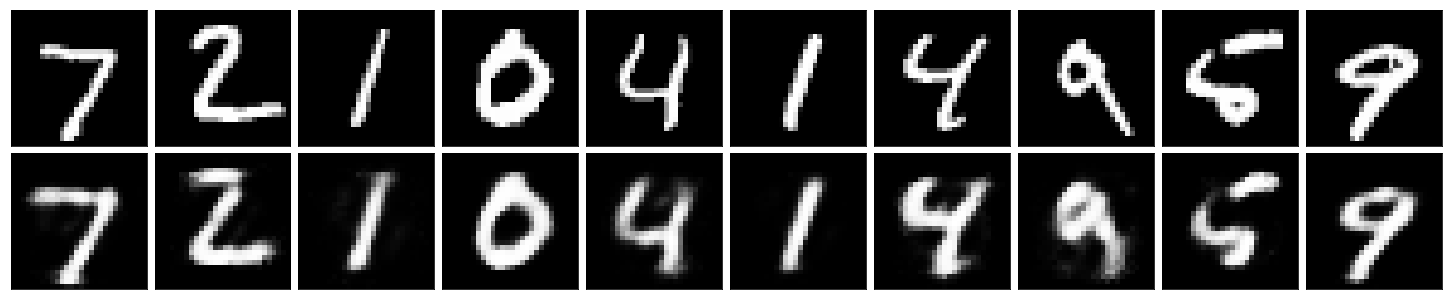

In [43]:
fig, axes = plt.subplots(nrows=2, ncols=10, sharex=True, sharey=True, figsize=(20,4))
in_imgs = mnist.test.images[:10]
reconstructed = sess.run(fetches=g_out, feed_dict={x: in_imgs})
print(reconstructed.shape)

for images, row in zip([in_imgs, reconstructed], axes):
    for img, ax in zip(images, row):
        ax.imshow(img.reshape((28, 28)), cmap='Greys_r')
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
fig.tight_layout(pad=0.1)

In [44]:
Xtest = mnist.test.images[:]
Xtest_ = sess.run(fetches=g_out, feed_dict={x: Xtest})

In [45]:
Xvalid = mnist.validation.images[:]
Xvalid_ = sess.run(fetches=g_out, feed_dict={x: Xvalid})

In [46]:
Xtrain = mnist.train.images[:]
Xtrain_ = sess.run(fetches=g_out, feed_dict={x: Xtrain})

In [47]:
sess.close()

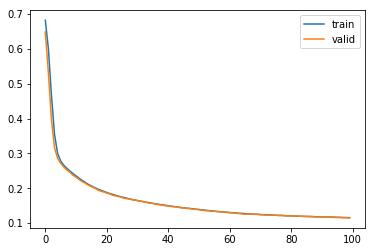

In [48]:
# plotting
plt.plot(train_loss_batch, label='train')
plt.plot(valid_loss_batch, label='valid')
plt.legend()
plt.show()

## Up Next

We're dealing with images here, so we can (usually) get better performance using convolution layers. So, next we'll build a better autoencoder with convolutional layers.

In practice, autoencoders aren't actually better at compression compared to typical methods like JPEGs and MP3s. But, they are being used for noise reduction, which you'll also build.

In [49]:
def discriminator(x, x_units, h_units, trainable):
    # input to hidden layer: x2h
    initial_value = tf.random_normal(dtype=tf.float32, mean=0.0, shape=[x_units, h_units], stddev=0.1)
    wd_x2h = tf.Variable(initial_value=initial_value, trainable=trainable)
    print(wd_x2h.shape, wd_x2h.dtype)
    h = tf.matmul(a=x, b=wd_x2h)
    h = tf.maximum(x=(0.1*h), y=h)
    print(h.shape, h.dtype)

    # hidden to outout which has the input size
    initial_value = tf.random_normal(dtype=tf.float32, mean=0.0, shape=[h_units, 2], stddev=0.1)
    wd_h2y = tf.Variable(initial_value=initial_value, trainable=trainable)
    print(wd_h2y.shape, wd_h2y.dtype)
    logits = tf.matmul(a=h, b=wd_h2y)
    # Softmax output from
    out = tf.nn.softmax(logits)
    print(out.shape, out.dtype)
    
    return out, logits

In [50]:
# Size of the encoding layer (the hidden layer)
h_units = 32
x_units = mnist.validation.images.shape[1]
print(h_units, x_units)

# input tensor
x = tf.placeholder(dtype=tf.float32, shape=(None, x_units))
y = tf.placeholder(dtype=tf.uint8, shape=(None, 2))
print(x.shape, x.dtype)
print(y.shape, y.dtype)

32 784
(?, 784) <dtype: 'float32'>
(?, 2) <dtype: 'uint8'>


In [51]:
d_out, d_logits = discriminator(h_units=h_units, trainable=True, x=x, x_units=x_units)
d_loss_batch = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y, logits=d_logits)
d_loss = tf.reduce_mean(d_loss_batch)
d_opt = tf.train.AdamOptimizer().minimize(d_loss)

(784, 32) <dtype: 'float32_ref'>
(?, 32) <dtype: 'float32'>
(32, 2) <dtype: 'float32_ref'>
(?, 2) <dtype: 'float32'>


In [52]:
# Accuracy
Ylogits_argmax = tf.argmax(input=d_logits, axis=1)
print(Ylogits_argmax)
Ylabels_argmax = tf.argmax(input=y, axis=1)
print(Ylabels_argmax)
accuracy = tf.equal(x=Ylogits_argmax, y=Ylabels_argmax, name=None)
print(accuracy)
accuracy = tf.cast(x=accuracy, dtype=tf.float32)
print(accuracy)
accuracy = tf.reduce_mean(input_tensor=accuracy, name=None)
print(accuracy)

Tensor("ArgMax_2:0", shape=(?,), dtype=int64)
Tensor("ArgMax_3:0", shape=(?,), dtype=int64)
Tensor("Equal_1:0", shape=(?,), dtype=bool)
Tensor("Cast_1:0", shape=(?,), dtype=float32)
Tensor("Mean_5:0", shape=(), dtype=float32)


In [53]:
# train, test, and validation
# X, X_ and Y, Y_
# real = 1, fake = 0
# real is 2 and fake is 1
Ytrain = np.ones(len(Xtrain), dtype=int)*2
Ytrain_ = np.ones(len(Xtrain_), dtype=int)
Yvalid = np.ones(len(Xvalid), dtype=int)*2
Yvalid_ = np.ones(len(Xvalid_), dtype=int)
Ytest = np.ones(len(Xtest), dtype=int)*2
Ytest_ = np.ones(len(Xtest_), dtype=int)

In [54]:
print(Ytrain.shape, Ytrain.dtype, Ytrain[:10])
print(Ytrain_.shape, Ytrain_.dtype, Ytrain_[:10])
print(Yvalid.shape, Yvalid.dtype, Yvalid[:10])
print(Yvalid_.shape, Yvalid_.dtype, Yvalid_[:10])
print(Ytest.shape, Ytest.dtype, Ytest[:10])
print(Ytest_.shape, Ytest_.dtype, Ytest_[:10])

(55000,) int64 [2 2 2 2 2 2 2 2 2 2]
(55000,) int64 [1 1 1 1 1 1 1 1 1 1]
(5000,) int64 [2 2 2 2 2 2 2 2 2 2]
(5000,) int64 [1 1 1 1 1 1 1 1 1 1]
(10000,) int64 [2 2 2 2 2 2 2 2 2 2]
(10000,) int64 [1 1 1 1 1 1 1 1 1 1]


In [55]:
# Onehotencoding of the output labels
def onehot(labels, n_class):
	""" One-hot encoding """
	expansion = np.eye(n_class)
	y = expansion[:, labels-1].T
	assert y.shape[1] == n_class, "Wrong number of labels!"

	return y

Ytrain=onehot(labels=Ytrain, n_class=2)
Ytest=onehot(labels=Ytest, n_class=2)
Yvalid=onehot(labels=Yvalid, n_class=2)
Ytrain_=onehot(labels=Ytrain_, n_class=2)
Ytest_=onehot(labels=Ytest_, n_class=2)
Yvalid_=onehot(labels=Yvalid_, n_class=2)
print(Ytrain.shape, Ytrain.dtype, Ytest.shape, Ytest.dtype, Yvalid.shape, Yvalid.dtype)
print(Ytrain_.shape, Ytrain_.dtype, Ytest_.shape, Ytest_.dtype, Yvalid_.shape, Yvalid_.dtype)

(55000, 2) float64 (10000, 2) float64 (5000, 2) float64
(55000, 2) float64 (10000, 2) float64 (5000, 2) float64


In [56]:
def get_batches(X, Y, batch_size):
    """ Return a generator for batches """
    n_batches = len(X) // batch_size
    X, Y = X[:n_batches*batch_size], Y[:n_batches*batch_size]

    # Loop over batches and yield
    for b in range(0, len(X), batch_size):
        yield X[b:b+batch_size], Y[b:b+batch_size]

In [57]:
# train and loss list
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []

# Save the training result or trained and validated model params
saver = tf.train.Saver()

# batch size
batch_size = Xvalid.shape[0]

with tf.Session() as sess:
    sess.run(fetches=tf.global_variables_initializer())
   
    # Loop over epochs
    epochs = 100
    for epoch in range(epochs):
        
        # Loop over batches of training 
        loss_batch, acc_batch = [], []
        # real batch
        for Xarr, Yarr in get_batches(X=Xtrain, Y=Ytrain, batch_size=batch_size):
            feed_dict = {x:Xarr, y:Yarr}
            lossarr, _, accarr = sess.run(fetches=[d_loss, d_opt, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
        # fake batch
        for Xarr, Yarr in get_batches(X=Xtrain_, Y=Ytrain_, batch_size=batch_size):
            feed_dict = {x:Xarr, y:Yarr}
            lossarr, _, accarr = sess.run(fetches=[d_loss, d_opt, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        train_loss.append(np.mean(loss_batch))
        train_acc.append(np.mean(acc_batch))

        # Loop over batches of training 
        loss_batch, acc_batch = [], []
        # real batch
        for Xarr, Yarr in get_batches(X=Xvalid, Y=Yvalid, batch_size=batch_size):
            feed_dict = {x:Xarr, y:Yarr}
            lossarr, accarr = sess.run(fetches=[d_loss, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
        # fake batch
        for Xarr, Yarr in get_batches(X=Xvalid_, Y=Yvalid_, batch_size=batch_size):
            feed_dict = {x:Xarr, y:Yarr}
            lossarr, accarr = sess.run(fetches=[d_loss, accuracy], feed_dict=feed_dict)
            loss_batch.append(lossarr)
            acc_batch.append(accarr)
            
        # acc and loss for plotting
        valid_loss.append(np.mean(loss_batch))
        valid_acc.append(np.mean(acc_batch))
        
        # Print info for every iter/epoch
        print("Epoch: {}/{}".format(epoch+1, epochs),
              "Train loss: {:6f}".format(train_loss[epoch]),  
              "Valid loss: {:6f}".format(valid_loss[epoch]),
              "Train accuracy: {:6f}".format(train_acc[epoch]),  
              "Valid accuracy: {:6f}".format(valid_acc[epoch]))  
        
    saver.save(sess, 'checkpoints/discriminator.ckpt')

Epoch: 1/100 Train loss: 1.363546 Valid loss: 0.846987 Train accuracy: 0.492264 Valid accuracy: 0.499600
Epoch: 2/100 Train loss: 0.647395 Valid loss: 0.694102 Train accuracy: 0.553273 Valid accuracy: 0.523700
Epoch: 3/100 Train loss: 0.731742 Valid loss: 0.687351 Train accuracy: 0.373364 Valid accuracy: 0.549600
Epoch: 4/100 Train loss: 0.711944 Valid loss: 0.684982 Train accuracy: 0.419827 Valid accuracy: 0.562700
Epoch: 5/100 Train loss: 0.705585 Valid loss: 0.683973 Train accuracy: 0.443418 Valid accuracy: 0.570500
Epoch: 6/100 Train loss: 0.703270 Valid loss: 0.683322 Train accuracy: 0.453582 Valid accuracy: 0.577300
Epoch: 7/100 Train loss: 0.702051 Valid loss: 0.682823 Train accuracy: 0.456973 Valid accuracy: 0.583700
Epoch: 8/100 Train loss: 0.701158 Valid loss: 0.682374 Train accuracy: 0.459882 Valid accuracy: 0.590700
Epoch: 9/100 Train loss: 0.700362 Valid loss: 0.681974 Train accuracy: 0.462473 Valid accuracy: 0.596400
Epoch: 10/100 Train loss: 0.699700 Valid loss: 0.681630

Epoch: 79/100 Train loss: 0.677318 Valid loss: 0.631273 Train accuracy: 0.555191 Valid accuracy: 0.741700
Epoch: 80/100 Train loss: 0.672765 Valid loss: 0.627299 Train accuracy: 0.627745 Valid accuracy: 0.756900
Epoch: 81/100 Train loss: 0.674789 Valid loss: 0.627239 Train accuracy: 0.557191 Valid accuracy: 0.743500
Epoch: 82/100 Train loss: 0.670793 Valid loss: 0.622957 Train accuracy: 0.634109 Valid accuracy: 0.760900
Epoch: 83/100 Train loss: 0.672850 Valid loss: 0.623848 Train accuracy: 0.557582 Valid accuracy: 0.742600
Epoch: 84/100 Train loss: 0.669535 Valid loss: 0.618687 Train accuracy: 0.640100 Valid accuracy: 0.764000
Epoch: 85/100 Train loss: 0.671003 Valid loss: 0.619129 Train accuracy: 0.559836 Valid accuracy: 0.746400
Epoch: 86/100 Train loss: 0.666543 Valid loss: 0.613459 Train accuracy: 0.647255 Valid accuracy: 0.768400
Epoch: 87/100 Train loss: 0.668320 Valid loss: 0.614692 Train accuracy: 0.564191 Valid accuracy: 0.748100
Epoch: 88/100 Train loss: 0.664602 Valid loss:

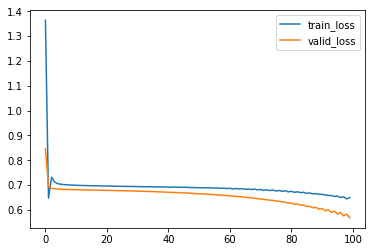

In [58]:
import matplotlib.pyplot as mplot
%matplotlib inline

mplot.plot(train_loss, label='train_loss')
mplot.plot(valid_loss, label='valid_loss')
mplot.legend()
mplot.show()

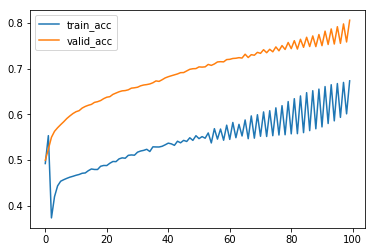

In [59]:
# import matplotlib.pyplot as mplot
mplot.plot(train_acc, label='train_acc')
mplot.plot(valid_acc, label='valid_acc')
mplot.legend()
mplot.show()

In [61]:
with tf.Session() as sess:
    # Restore the validated model
    # saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    saver.restore(sess=sess, save_path='checkpoints/discriminator.ckpt')
    
    # Loop over batches of Test
    loss_batch, acc_batch = [], []
    # Real batches
    for Xarr, Yarr in get_batches(X=Xtest, Y=Ytest, batch_size=batch_size):
        # Feed dictionary
        feed_dict = {x:Xarr, y:Yarr}
        lossarr, accarr = sess.run(fetches=[d_loss, accuracy], feed_dict=feed_dict)
        loss_batch.append(lossarr)
        acc_batch.append(accarr)
    # Fake batches
    for Xarr, Yarr in get_batches(X=Xtest_, Y=Ytest_, batch_size=batch_size):
        # Feed dictionary
        feed_dict = {x:Xarr, y:Yarr}
        lossarr, accarr = sess.run(fetches=[d_loss, accuracy], feed_dict=feed_dict)
        loss_batch.append(lossarr)
        acc_batch.append(accarr)

    # Print info for every iter/epoch
    print("Test loss: {:6f}".format(np.mean(loss_batch)),
          "Test acc: {:.6f}".format(np.mean(acc_batch)))

INFO:tensorflow:Restoring parameters from checkpoints/discriminator.ckpt
Test loss: 0.573440 Test acc: 0.799250
